In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from tqdm.autonotebook import tqdm
import seaborn as sns
from Environments.igt import IGTEnv
from BasalGanglia.train import train
import pickle
from utils.utils import load_yaml
import math
from scipy.stats import t
import pandas as pd
import os

C:\Users\chari\AppData\Local\Temp\ipykernel_5400\1845841874.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load Hyperarameters


In [ ]:
params = load_yaml(os.path.join(os.getcwd(), r'hyperparams\IGT_hyperparams.yaml'))

In [ ]:
TRAILS = params['TRAILS']
EPOCHS = params['EPOCHS'] 
NUM_BINS = params['NUM_BINS']
LR = params['LR'] #0.00075
NUM_ARMS = params['NUM_ARMS']
SCALING_FACTOR = params['SCALING_FACTOR']
REW_STD = params['REW_STD']
LOSS_STD = params['LOSS_STD']

## Environment

In [17]:
env = IGTEnv(mean_reward=np.array([100,100,50,50])/SCALING_FACTOR,
             std_reward=np.array([REW_STD,REW_STD,REW_STD,REW_STD])/SCALING_FACTOR,
             mean_loss=np.array([-250,-1250,-50,-250])/SCALING_FACTOR,
             std_loss=np.array([LOSS_STD,LOSS_STD,LOSS_STD,LOSS_STD])/SCALING_FACTOR)

## Training

In [ ]:
reward_monitor, arm_chosen_monitor, avg_counts,ip_monitor, dp_monitor,ep_monitor= train(env, 
                                                      trails = TRAILS, 
                                                      epochs = EPOCHS, 
                                                      lr = LR, 
                                                      bins = NUM_BINS,
                                                      STN_data = None,
                                                      d1_amp=0.5,
                                                      d2_amp=0.1, 
                                                      gpi_threshold=0.15,
                                                      max_gpi_iters=50, 
                                                      del_lim=None, train_IP = False, 
                                                      del_med = None, printing = False,
                                                      gpi_mean= 1, ep_0 = 0.1,
                                                      alpha_ep = 0.001,
                                                      eta_ep = 0.1,
                                                      baseline_ep = 0.0, ep_lim=None)


Using Random noise
0: dp: tensor([[0.2504, 0.2504, 0.2504, 0.2504]], grad_fn=<MulBackward0>), arm_chosen:0, TD error: tensor([-1.7504], grad_fn=<RsubBackward1>), epsilon: 0.10090000182390213
1: dp: tensor([[0.2500, 0.2504, 0.2504, 0.2504]], grad_fn=<MulBackward0>), arm_chosen:3, TD error: tensor([0.2496], grad_fn=<RsubBackward1>), epsilon: 0.10126283764839172
2: dp: tensor([[0.2500, 0.2504, 0.2504, 0.2782]], grad_fn=<MulBackward0>), arm_chosen:3, TD error: tensor([0.2218], grad_fn=<RsubBackward1>), epsilon: 0.10155025124549866
3: dp: tensor([[0.2500, 0.2504, 0.2504, 0.3147]], grad_fn=<MulBackward0>), arm_chosen:3, TD error: tensor([0.1853], grad_fn=<RsubBackward1>), epsilon: 0.10173939913511276
4: dp: tensor([[0.2500, 0.2505, 0.2505, 0.3568]], grad_fn=<MulBackward0>), arm_chosen:3, TD error: tensor([0.1432], grad_fn=<RsubBackward1>), epsilon: 0.10182318091392517
5: dp: tensor([[0.2500, 0.2505, 0.2505, 0.3978]], grad_fn=<MulBackward0>), arm_chosen:3, TD error: tensor([-2.3978], grad_fn=

## Analysis

In [35]:
A_picks = avg_counts[0]
B_picks = avg_counts[1]
C_picks = avg_counts[2]
D_picks = avg_counts[3]

Avg_A_picks = torch.mean(A_picks, dim = 0)
Avg_B_picks = torch.mean(B_picks, dim = 0)
Avg_C_picks = torch.mean(C_picks, dim = 0)
Avg_D_picks = torch.mean(D_picks, dim = 0)

IGT_score = torch.mean(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0).squeeze().numpy()
IGT_dev = torch.std(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0)/torch.sqrt(torch.tensor(EPOCHS, dtype = torch.float32))
IGT_dev = IGT_dev.squeeze().numpy()

print(f'IGT score: {IGT_score} with SE of {IGT_dev}')

IGT score: [1.28 3.   4.4  4.78 5.32] with SE of [1.7109321 1.7801373 1.6812694 1.5103401 1.461484 ]


In [36]:
A_picks = avg_counts[0]
B_picks = avg_counts[1]
C_picks = avg_counts[2]
D_picks = avg_counts[3]

Avg_A_picks = torch.mean(A_picks, dim = 0)
Avg_B_picks = torch.mean(B_picks, dim = 0)
Avg_C_picks = torch.mean(C_picks, dim = 0)
Avg_D_picks = torch.mean(D_picks, dim = 0)

IP_A = torch.mean(ip_monitor[0], dim = 0).detach().numpy()
IP_B = torch.mean(ip_monitor[1], dim = 0).detach().numpy()
IP_C = torch.mean(ip_monitor[2], dim = 0).detach().numpy()
IP_D = torch.mean(ip_monitor[3], dim = 0).detach().numpy()

DP_A = torch.mean(dp_monitor[0], dim = 0).detach().numpy()
DP_B = torch.mean(dp_monitor[1], dim = 0).detach().numpy()
DP_C = torch.mean(dp_monitor[2], dim = 0).detach().numpy()
DP_D = torch.mean(dp_monitor[3], dim = 0).detach().numpy()

IGT_score = torch.mean(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0)
IGT_dev = torch.std(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0)/torch.sqrt(torch.tensor(EPOCHS, dtype = torch.float32))

IP_all = np.array([IP_A[:,0],IP_B[:,0],IP_C[:,0],IP_D[:,0]])
IP_Var = np.std(IP_all,axis = 0 )

## Results

Text(0.5, 0, 'trails')

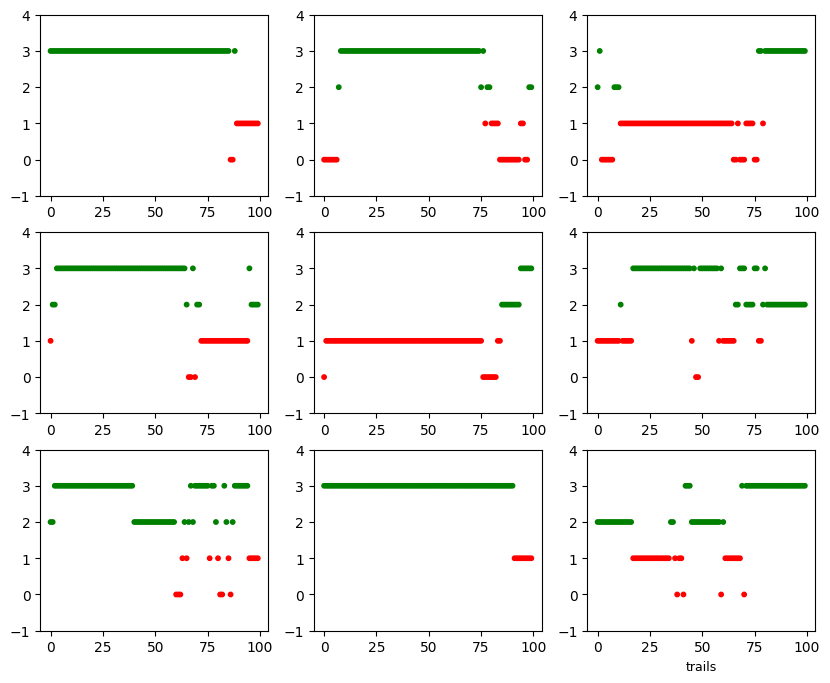

In [ ]:
random_pick = np.random.choice(np.arange(EPOCHS), size = 9)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    colors = np.where(np.isin(arm_chosen_monitor[random_pick[i]],[0,1]), 'r', 'g')
    plt.scatter(np.arange(TRAILS), arm_chosen_monitor[random_pick[i]], c = colors, s = 10)
    plt.ylim(-1,4)
plt.xlabel('trails', fontsize = 9)


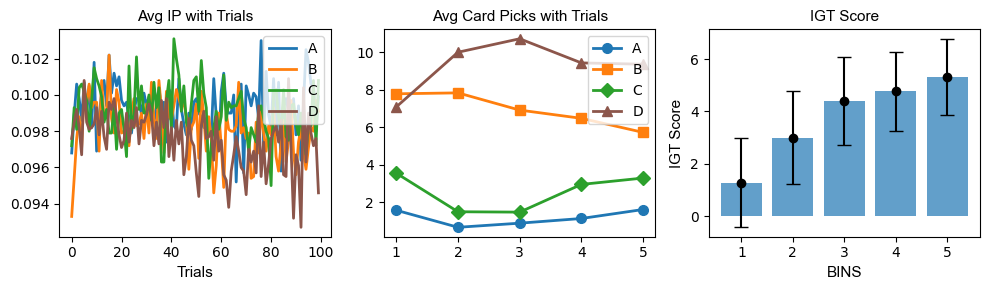

In [ ]:
BINS = np.arange(5) + 1

plt.figure(figsize=(10, 3))
font = {'family': 'Arial', 'size': 11}

plt.subplot(131)
plt.plot(np.arange(100), IP_A, label='A', color='#1f77b4', linewidth=2)
plt.plot(np.arange(100), IP_B, label='B', color='#ff7f0e', linewidth=2)
plt.plot(np.arange(100), IP_C, label='C', color='#2ca02c', linewidth=2)
plt.plot(np.arange(100), IP_D, label='D', color='#8c564b', linewidth=2)
plt.xlabel('Trials', **font)
plt.title('Avg IP with Trials', **font)
plt.legend(loc='upper right', fontsize=10)

plt.subplot(132)
plt.plot(BINS, Avg_A_picks, label='A', color='#1f77b4', marker='o', markersize=7, linewidth=2)
plt.plot(BINS, Avg_B_picks, label='B', color='#ff7f0e', marker='s', markersize=7, linewidth=2)
plt.plot(BINS, Avg_C_picks, label='C', color='#2ca02c', marker='D', markersize=7, linewidth=2)
plt.plot(BINS, Avg_D_picks, label='D', color='#8c564b', marker='^', markersize=7, linewidth=2)
plt.title('Avg Card Picks with Trials', **font)
plt.legend(loc='upper right', fontsize=10)

plt.subplot(133)
plt.bar(BINS, IGT_score.reshape(5), color='#1f77b4', alpha=0.7)
plt.errorbar(BINS, IGT_score.reshape(5), yerr=IGT_dev.reshape(5), fmt='o', color='black', capsize=5)
plt.title('IGT Score', **font)
plt.xlabel('BINS', **font)
plt.ylabel('IGT Score', **font)

plt.tight_layout()

In [68]:
IGT_expt= np.array([-1.83,1.5,2.6,4.59,3.9])
IGT_Simulated = IGT_score.reshape(5)

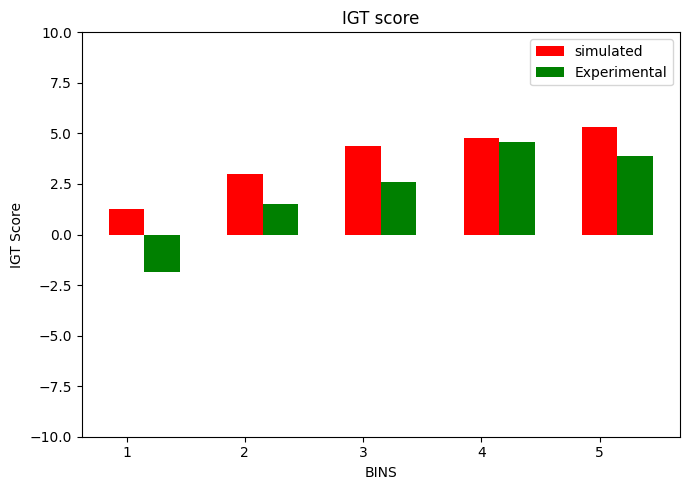

In [51]:
# Plotting bar for IGT
plt.figure(figsize=(7,5))
plt.bar(BINS, IGT_Simulated, width=0.3, color = 'red', label = 'simulated')
plt.bar(BINS+0.3, IGT_expt, width=0.3, color = 'green', label = 'Experimental')
plt.ylim(-10,10)
plt.title(f'IGT score')
plt.xlabel('BINS')
plt.ylabel('IGT Score')
plt.legend()
plt.tight_layout()

## Statistical testing

In [57]:
mean_sim = IGT_score.squeeze().detach().numpy()
mean_expt = IGT_expt
std_sim = torch.std(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0).squeeze().detach().numpy()
std_expt = std_sim
n_sim = EPOCHS
n_expt = 20

In [ ]:
def compare_multiple_pairs(mean_exp, std_exp, n_exp, mean_sim, std_sim, n_sim):
    results = []

    for i in range(len(mean_exp)):
        m1, s1 = mean_exp[i], std_exp[i]
        m2, s2 = mean_sim[i], std_sim[i]

        # Standard error
        se = math.sqrt((s1**2)/n_exp + (s2**2)/n_sim)

        # t-statistic
        t_stat = (m1 - m2) / se

        # Degrees of freedom (Welch-Satterthwaite)
        df_num = (s1**2/n_exp + s2**2/n_sim)**2
        df_den = ((s1**2/n_exp)**2 / (n_exp - 1)) + ((s2**2/n_sim)**2 / (n_sim - 1))
        df = df_num / df_den

        # Two-tailed p-value
        p_val = 2 * (1 - t.cdf(abs(t_stat), df))
        conclusion = "Statistically different" if p_val < 0.05 else "Not statistically different"

        results.append({
            "Index": i+1,
            "Exp Mean": m1,
            "Sim Mean": m2,
            "t-stat": round(t_stat, 3),
            "p-value": round(p_val, 4),
            "Significant": p_val < 0.05,
            "Conclusion": conclusion

        })

    return pd.DataFrame(results)

# Run comparison
df_results_IGT_mean = compare_multiple_pairs(mean_expt, std_expt, n_expt, mean_sim, std_sim, n_sim)

# Show results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Significance Comparison Results", dataframe=df_results)


In [44]:
df_results_IGT_mean

,Index,Exp Mean,Sim Mean,t-stat,p-value,Significant,Conclusion
0,1,-1.83,1.28,-0.742,0.4644,False,Not statistically different
1,2,1.50,3.00,-0.344,0.7335,False,Not statistically different
2,3,2.60,4.40,-0.437,0.6655,False,Not statistically different
3,4,4.59,4.78,-0.051,0.9594,False,Not statistically different
4,5,3.90,5.32,-0.397,0.6947,False,Not statistically different
